In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
from plot_utils import cool_savefig

In [3]:
small_batches_compositions = np.zeros((1500*500))
medium_batches_compositions = np.zeros((30*500))
large_batches_compositions = np.zeros((500))

In [4]:
from glob import glob

filenames = sorted(list(glob('concentration_ML_estimates/*.compositional.npz')))
len(filenames)

500

In [5]:
for sim_num in range(500):
    npzfile = np.load(filenames[sim_num])
    
    small_batches_compositions[sim_num*1500:(sim_num+1)*1500] = npzfile['small_batches']
    medium_batches_compositions[sim_num*30:(sim_num+1)*30] = npzfile['medium_batches']
    large_batches_compositions[sim_num] = npzfile['whole_sim']

In [6]:
print(np.mean(small_batches_compositions < np.inf))
print(np.mean(medium_batches_compositions < np.inf))
print(np.mean(large_batches_compositions < np.inf))

0.601332
0.8771333333333333
1.0


a priori we know that estimates less than $0$ (which then were "manually" changed to $0$) are junk caused by `fsolve` being dumb -- so let's try to gauge what percentage of the data is affected by this problem

In [7]:
print(np.mean(small_batches_compositions > 0))
print(np.mean(medium_batches_compositions > 0))
print(np.mean(large_batches_compositions > 0))

0.997168
0.9878
1.0


we know a priori that "estimates" of $0$ result from the root finder not working, so let's just throw those out...

In [8]:
small_batches_compositions = small_batches_compositions[small_batches_compositions > 0]
medium_batches_compositions = medium_batches_compositions[medium_batches_compositions > 0]
large_batches_compositions = large_batches_compositions[large_batches_compositions > 0]

In [9]:
def small_part(array, x): return array[array < x]
def finite_part(array): return small_part(array, np.inf)

In [10]:
def x_fmt(x, pos):
    return '$10^{{{}}}$'.format(x).replace('.0','').replace('.5', '')

In [11]:
from statsmodels.distributions.empirical_distribution import ECDF

In [12]:
def crest(index):
    return sns.color_palette("crest")[index]

def magma(index):
    return sns.color_palette("magma")[index]

# Compositional Heterogeneity

In [13]:
small_ecdf_comp = ECDF(small_batches_compositions)
medium_ecdf_comp = ECDF(medium_batches_compositions)
large_ecdf_comp = ECDF(large_batches_compositions)

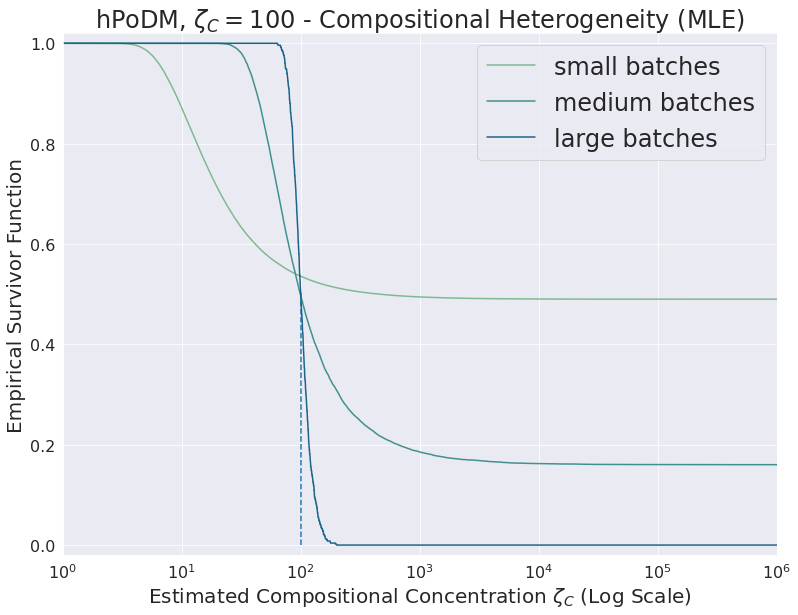

In [14]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12.8,9.6))
    xvals = np.logspace(start=0, stop=6, num=10000)
    axis = sns.lineplot(x=np.log(xvals)/np.log(10), y=1.-small_ecdf_comp(xvals), color=crest(0))
    sns.lineplot(x=np.log(xvals)/np.log(10), y=1.-medium_ecdf_comp(xvals), color=crest(2))
    sns.lineplot(x=np.log(xvals)/np.log(10), y=1. - large_ecdf_comp(xvals), color=crest(4))
    axis.legend(labels=["small batches", "medium batches", "large batches"], fontsize=24)
    axis.set_ylabel('Empirical Survivor Function', fontsize=20)
    axis.set_ylim((-0.02,1.02))
    plt.stem([2], [1.-large_ecdf_comp(100)], markerfmt='', linefmt='--')
    axis.set_xlim((0,6))
    axis.set_xlabel('Estimated Compositional Concentration $\zeta_C$ (Log Scale)', fontsize=20)
    axis.xaxis.set_major_formatter(mtick.FuncFormatter(x_fmt))
    axis.tick_params(labelsize=16)
    title = 'hPoDM, $\zeta_C=100$ - Compositional Heterogeneity (MLE)'
    plt.title(title, fontsize=24)
    cool_savefig(title + ' survival')

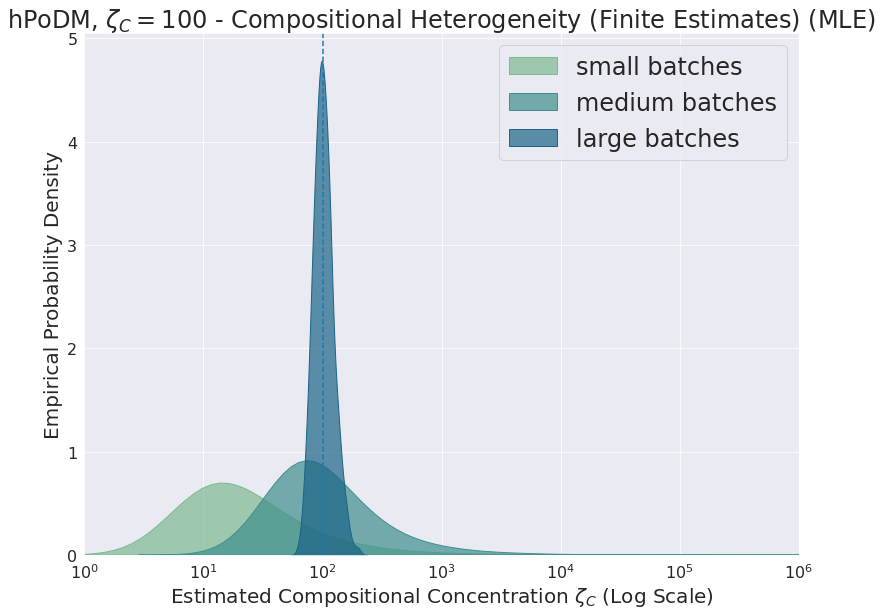

In [15]:
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(12.8, 9.6))
    axis = sns.kdeplot(np.log(finite_part(small_batches_compositions))/np.log(10), color=crest(0), alpha=0.7, fill=True)
    sns.kdeplot(np.log(finite_part(medium_batches_compositions))/np.log(10), ax=axis, color=crest(2), alpha=0.7, fill=True)
    sns.kdeplot(np.log(finite_part(large_batches_compositions))/np.log(10), ax=axis, color=crest(4), alpha=0.7, fill=True)
    axis.legend(labels=["small batches", "medium batches", "large batches"], fontsize=24)
    axis.xaxis.set_major_formatter(mtick.FuncFormatter(x_fmt))
    axis.set_ylabel('Empirical Probability Density', fontsize=20)
    axis.set_xlabel('Estimated Compositional Concentration $\zeta_C$ (Log Scale)', fontsize=20)
    axis.tick_params(labelsize=16)
    axis.set_xlim((0,6))
    axis.set_ylim((0,5.05))
    plt.stem([2], [5.1], markerfmt='', linefmt='--')
    title = 'hPoDM, $\zeta_C=100$ - Compositional Heterogeneity (Finite Estimates) (MLE)'
    plt.title(title, fontsize=24)
    cool_savefig(title + ' kde')